In [4]:
import pandas as pd

# Lecture des fichiers CSV
carac_2005 = pd.read_csv("donnee_accident/Donnee_2005/caracteristiques_2005.csv", sep=",", encoding="latin1", on_bad_lines='skip')
lieux_2005 = pd.read_csv("donnee_accident/Donnee_2005/lieux_2005.csv", sep=",", encoding="utf-8")
usagers_2005 = pd.read_csv("donnee_accident/Donnee_2005/usagers_2005.csv", sep=",", encoding="utf-8")
vehicules_2005 = pd.read_csv("donnee_accident/Donnee_2005/vehicules_2005.csv", sep=",", encoding="utf-8")

In [5]:
# Fusion 1: caracteristiques + lieux
df_2005 = pd.merge(carac_2005, lieux_2005, on="Num_Acc", how="left")

# Fusion 2: + véhicules
df_2005 = pd.merge(df_2005, vehicules_2005, on="Num_Acc", how="left")

# Fusion 3: + usagers
df_2005 = pd.merge(df_2005, usagers_2005, on=["Num_Acc", "num_veh"], how="left")

# Ajout de colonne datetime
df_2005["date_heure"] = pd.to_datetime(
    df_2005["an"].astype(str).str.zfill(2) + "-" +
    df_2005["mois"].astype(str).str.zfill(2) + "-" +
    df_2005["jour"].astype(str).str.zfill(2) + " " +
    df_2005["hrmn"].astype(str).str.zfill(4).str[:2] + ":" +
    df_2005["hrmn"].astype(str).str.zfill(4).str[2:],
    errors="coerce"
)

df_2005["annee"] = 2005


C:\Users\lukas\AppData\Local\Temp\ipykernel_22888\1259095318.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2005["date_heure"] = pd.to_datetime(


In [6]:
# Dictionnaires
grav_dict = {1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"}
atm_dict = {
    1: "Normale", 2: "Pluie légère", 3: "Pluie forte", 4: "Neige - grêle", 
    5: "Brouillard - fumée", 6: "Vent fort - tempête", 7: "Temps éblouissant", 
    8: "Temps couvert", 9: "Autre", -1: "Non renseigné"
}

# Application
df_2005["grav_label"] = df_2005["grav"].map(grav_dict)
df_2005["atm_label"] = df_2005["atm"].map(atm_dict)
df_2005["heure"] = df_2005["date_heure"].dt.hour


<Axes: title={'center': 'Gravité des accidents'}, xlabel='grav_label'>

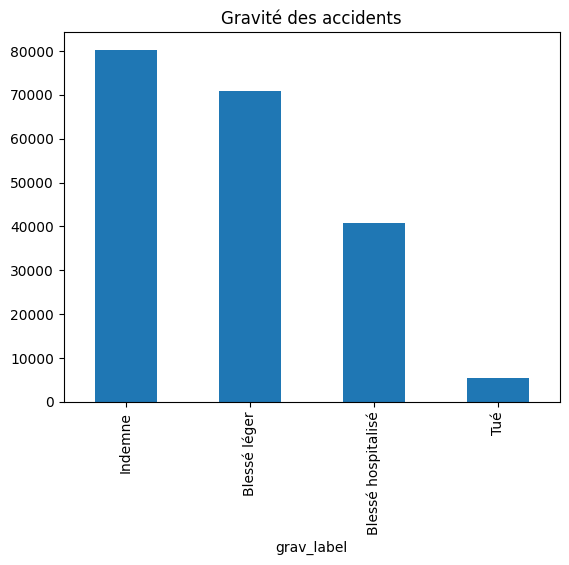

In [7]:
df_2005["grav_label"].value_counts().plot(kind="bar", title="Gravité des accidents")


<Axes: title={'center': 'Conditions météo'}, xlabel='atm_label'>

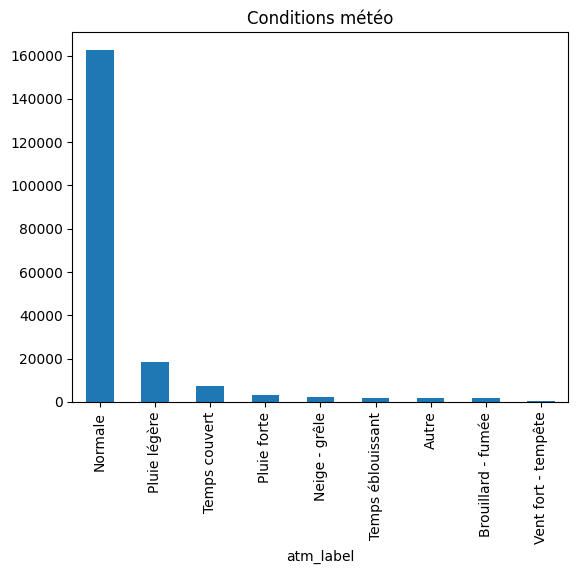

In [8]:
df_2005["atm_label"].value_counts().plot(kind="bar", title="Conditions météo")


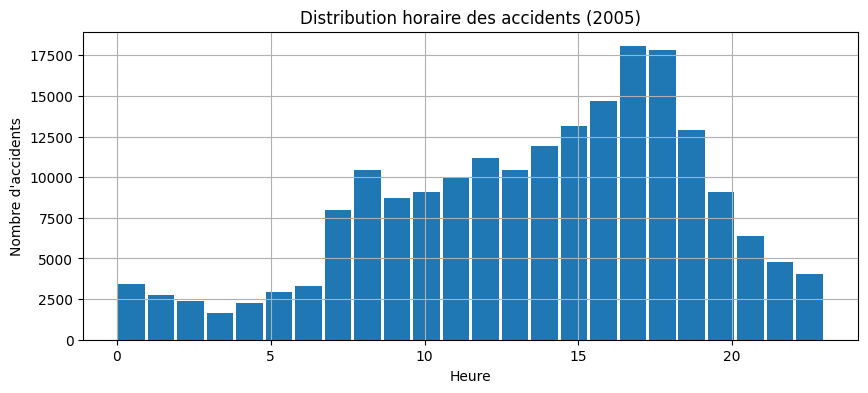

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
df_2005["heure"].dropna().astype(int).plot(kind="hist", bins=24, rwidth=0.9)
plt.title("Distribution horaire des accidents (2005)")
plt.xlabel("Heure")
plt.ylabel("Nombre d'accidents")
plt.grid(True)
plt.show()


In [15]:
import folium
from folium.plugins import MarkerCluster

# Centrage de la carte sur la France
map_2005 = folium.Map(location=[46.6, 2.2], zoom_start=6)

# Dictionnaire de gravité si ce n’est pas encore fait
grav_dict = {
    1: "Indemne",
    2: "Tué",
    3: "Blessé hospitalisé",
    4: "Blessé léger"
}
df_2005["grav_label"] = df_2005["grav"].map(grav_dict)

# Conversion coordonnées lat/long
def convert_lat(val):
    val_str = str(int(val)).zfill(7)
    return float(val_str[:2] + "." + val_str[2:]) if pd.notna(val) else None

def convert_lon(val):
    val_str = str(int(val)).zfill(6)
    return float(val_str[:1] + "." + val_str[1:]) if pd.notna(val) else None

# Création du cluster
marker_cluster = MarkerCluster().add_to(map_2005)

# Ajout des points dans le cluster
for _, row in df_2005.dropna(subset=["lat", "long"]).iterrows():
    try:
        lat = convert_lat(row["lat"])
        lon = convert_lon(row["long"])
        grav = row.get("grav_label", "Inconnue")

        folium.Marker(
            location=[lat, lon],
            popup=f"Gravité : {grav}"
        ).add_to(marker_cluster)
    except:
        continue  # Ignore les erreurs de conversion

# Enregistrement de la carte
map_2005.save("carte_accidents_2005.html")


In [19]:
bretagne_deps = ["022", "029", "035", "056"]
bretagne_accidents_brut = carac_2005[carac_2005["dep"].astype(str).str.zfill(3).isin(bretagne_deps)]

print(f"Nombre total d'accidents en Bretagne 2005 (tous cas) : {len(bretagne_accidents_brut)}")


Nombre total d'accidents en Bretagne 2005 (tous cas) : 0


In [44]:
import os
import pandas as pd

annees = [2005, 2008, 2011, 2014, 2017, 2020, 2023]
bretagne_deps = ["220", "290", "350", "560", "022", "029", "035", "056", "56", "22", "29", "35"]  # Ajout des zéros pour compatibilité
base_path = "donnee_accident/Donnee_"
resultats = []

for an in annees:
    chemin_1 = f"{base_path}{an}/caracteristiques_{an}.csv"
    chemin_2 = f"{base_path}{an}/caracteristiques-{an}.csv"
    chemin3= f"{base_path}{an}/caract-{an}.csv"

    if os.path.exists(chemin_1):
        chemin = chemin_1
    elif os.path.exists(chemin_2):
        chemin = chemin_2
    elif os.path.exists(chemin3):
        chemin = chemin3
    else:
        print(f"Fichier caractéristique non trouvé pour l'année {an}")
        resultats.append({"annee": an, "accidents_bretagne": None})
        continue

    try:
        df = pd.read_csv(chemin, sep=",", encoding="latin1", on_bad_lines='skip')
        df_bretagne = df[df["dep"].astype(str).str.zfill(3).isin(bretagne_deps)]
        nb_acc = len(df_bretagne)
    except Exception as e:
        nb_acc = None
        print(f"Erreur sur l'année {an}: {e}")
    resultats.append({"annee": an, "accidents_bretagne": nb_acc})

df_result = pd.DataFrame(resultats)
print(df_result)


C:\Users\lukas\AppData\Local\Temp\ipykernel_22888\3397204190.py:26: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(chemin, sep=",", encoding="latin1", on_bad_lines='skip')


Erreur sur l'année 2005: 'dep'
Erreur sur l'année 2020: 'dep'
Erreur sur l'année 2023: 'dep'
   annee  accidents_bretagne
0   2005                 NaN
1   2008              2845.0
2   2011              2641.0
3   2014              2369.0
4   2017              2637.0
5   2020                 NaN
6   2023                 NaN
